<a href="https://colab.research.google.com/github/darthVarada/leaningML/blob/main/03_computer_vision_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision


## 0. Computer vision libaries
* `torchvision` - base domain library for Pytorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - pretrained computer vision models that you can leverage for your problem
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


## 1. getting a dataset

the dataset we'l be using FashionMNIST from torchvision.datasets

In [2]:

# Setup training data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

### 1.1 check te input and output shapes of our data

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx

In [7]:
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### 1.2 Visualizing our data

Image shape: torch.Size([1, 28, 28])


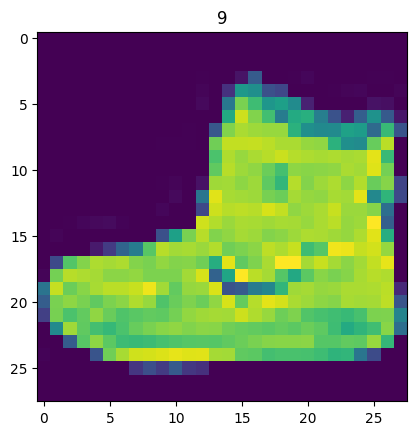

In [9]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label);
# image

(-0.5, 27.5, 27.5, -0.5)

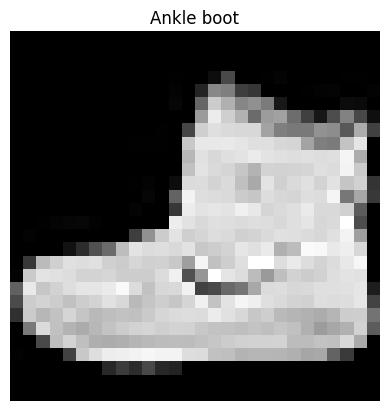

In [10]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);
plt.axis(False)

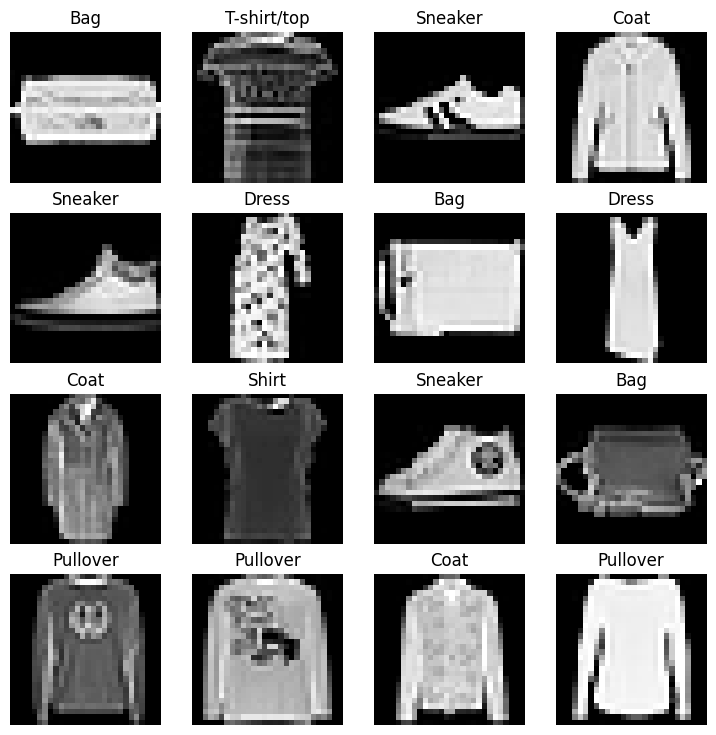

In [11]:
# plot more images
torch.manual_seed(4444)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

In [12]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare Dataloader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Pyton iterable.

More specifically, we want to turn our data into batches (or mini-batches).

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32)
2. It gives our neural network more chances to update
3. More on andrew ng minibatches

In [13]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7eedbae44c70>,
 <torch.utils.data.dataloader.DataLoader at 0x7eedbae446a0>)

In [14]:
# let's check out what we've created
print(f"DataLoader: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7eedbae44c70>, <torch.utils.data.dataloader.DataLoader object at 0x7eedbae446a0>)
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32


In [15]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 2, label size: torch.Size([])


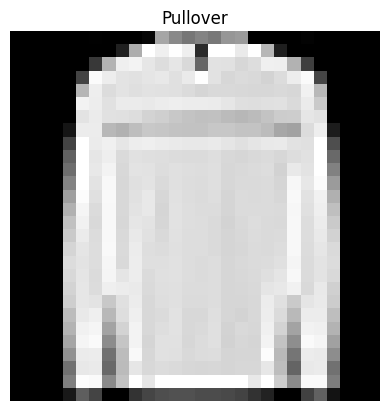

In [16]:

# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model

A baseline model is a simple model you try and improve upon with subsequent models/experiments.

in other words: start simply and add complexity when necessary

In [17]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]
x

# Flatten the sample
output = flatten_model(x) #perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [18]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [19]:
torch.manual_seed(42)

# setup model with input parameteres
model_0 = FashionMNISTModelV0(
    input_shape=28*28, # this is 784
    hidden_units= 10, # how many units in the hidden layer
    output_shape=len(class_names) # one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [21]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation metrics
Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
Evaluation metric - since we're working on a classification problem, let's use accruacy as our evaluation metric

In [22]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [23]:
#Import accuracy matric
from helper_functions import accuracy_fn

# setup loss functions and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to timeout our experiemnts

Machine Learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. how fast it runs

In [24]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Print defference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [25]:
# th
# at is how to timer a code
start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


4.8458999913236767e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per bathes*.
4. Print out what's happening.
5. Time it all (for fun)

In [26]:

[1, ]

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

    # Print out what's happening
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 39.563 seconds


## 4. Make predictions and get Model 0 results

In [27]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make predictions
      y_pred = model(X)

      #accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code (for using a GPU if there is one)

In [28]:
!nvidia-smi

Wed Nov  8 19:55:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
torch.cuda.is_available()

True

In [30]:
# setup device agnostic-code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity
We learned about the power of non-linearity in notebook 02 - https://www.learnpytorch.io/02_pytorch_classification/#6-the-missing-piece-non-linearity

In [31]:
# Create a model with non-linear layers and linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
    nn.Flatten(), # flatten inputs into a single vector
    nn.Linear(in_features=input_shape,
              out_features=hidden_units),
    nn.ReLU(),
    nn.Linear(in_features=hidden_units,
              out_features=output_shape),
    nn.ReLU()
    )
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)


In [32]:
# Crreate an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.1 setup loss, optimizer and evaluation metrics

In [33]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss() # mesure how wrong our model is
optimizer = torch.optim.SGD(params=model_1.parameters(), # tries to update our model's parameters to reduce the loss
                            lr=0.1)

### 6.2 functionizing training and evaluation/training loop

* trauning loop - `train-step()`
* testing loop - `test_step()`

In [34]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)

    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


In [35]:

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculuate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [36]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1
----------
Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%

Epoch: 2
----------
Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%

Train time on cuda: 34.459 seconds


> **Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.
>
> Why is this?
>
> 1. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.
> 2. The hardware you're using has a better CPU in terms compute capability than the GPU.

In [37]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

In [38]:

torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make our data device agnostic
      X, y = X.to(device), y.to(device)
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

In [39]:

# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [40]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

## Model 2: Building a Convolutional Neural Network (CNN)
CNN's are also known ConvNets

CNN's are known for their capabilities to find patterns in visual data

to find out what's happening inside a CNN, see this website: https://poloclub.github.io/cnn-explainer/

In [41]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [42]:

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [43]:
#model_2.state_dict()

### 7.1 Stepping through `nn.Conv2d()`

See the documentation for more information https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [44]:
torch. manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single batch shape: {test_image.shape}")
print(f"test image: {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single batch shape: torch.Size([3, 64, 64])
test image: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.

In [45]:
test_image.shape

torch.Size([3, 64, 64])

In [46]:
torch.manual_seed(42)
# Create a sinlge conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3, 3),
                       stride=1,
                       padding=0)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 62, 62])

### 7.2 Stepping through nn.MaxPool2d()
https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [47]:
test_image.shape

torch.Size([3, 64, 64])

In [48]:
# Print out original image shape withoput unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [49]:
torch.manual_seed(42)
# Create a random tesnor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"\nRandom tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")


Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for `model_2`

In [50]:
# setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)


In [51]:
model_2.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
           

### 7.4 Training and testing `model_2` using our trainning and test functions

In [52]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Mesure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epoch = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.59497 | Train acc: 78.45%
Test loss: 0.40134 | Test acc: 85.55%

Epoch: 1
--------
Train loss: 0.35809 | Train acc: 87.05%
Test loss: 0.35808 | Test acc: 86.59%

Epoch: 2
--------
Train loss: 0.32160 | Train acc: 88.38%
Test loss: 0.31774 | Test acc: 88.73%

Train time on cuda: 39.938 seconds


In [53]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3177354633808136,
 'model_acc': 88.72803514376997}

In [54]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

### 8. Compare model resuts and training time

In [55]:
import pandas as pd
compare_resuts = pd.DataFrame([model_0_results,
                              model_1_results,
                              model_2_results])

compare_resuts

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.317735,88.728035


In [56]:
#add training time to results comparison

compare_resuts ["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_resuts

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,39.562841
1,FashionMNISTModelV1,0.685001,75.019968,34.458848
2,FashionMNISTModelV2,0.317735,88.728035,39.937964


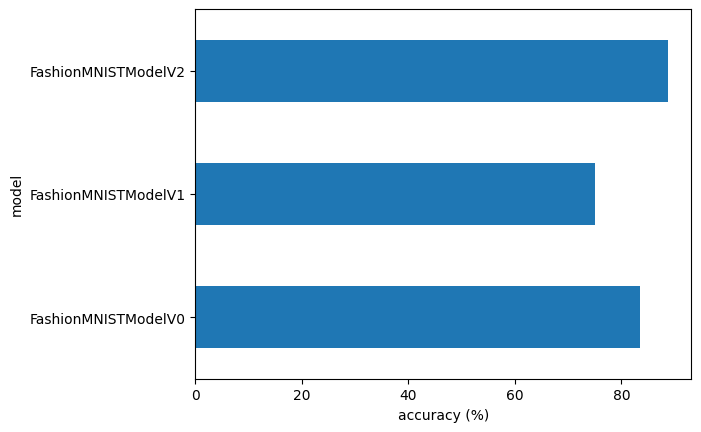

In [57]:
# Visualize our model results

compare_resuts.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## 9. Make and avaluate random predictions with best model

In [58]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs= []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass the target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forwarrd pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_prob to turn list into a tensor
  return torch.stack(pred_probs)

In [59]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

  #View the first samples shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

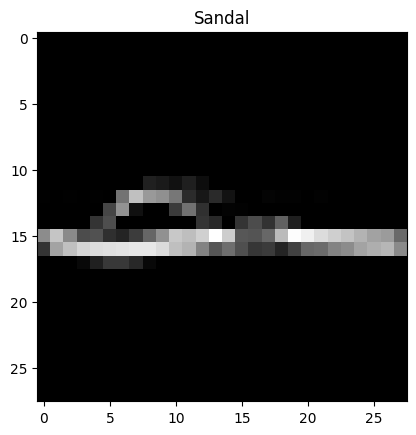

In [60]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [61]:
# Make predictions
pred_probs = make_predictions(model = model_2,
                              data=test_samples)

# View first two predictions probabilities
pred_probs[:2]

tensor([[1.6132e-04, 1.2834e-05, 4.0332e-05, 4.6259e-05, 2.3059e-06, 9.9608e-01,
         1.9199e-05, 1.5989e-03, 2.0378e-03, 3.2862e-06],
        [3.6941e-03, 1.8315e-04, 6.8485e-04, 1.8621e-04, 3.6959e-04, 2.3676e-04,
         1.7066e-02, 2.4608e-05, 9.7745e-01, 1.0212e-04]])

In [62]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 8, 5, 7, 4, 8, 9, 5, 6])

In [63]:
test_labels

[5, 8, 5, 7, 4, 8, 9, 5, 6]

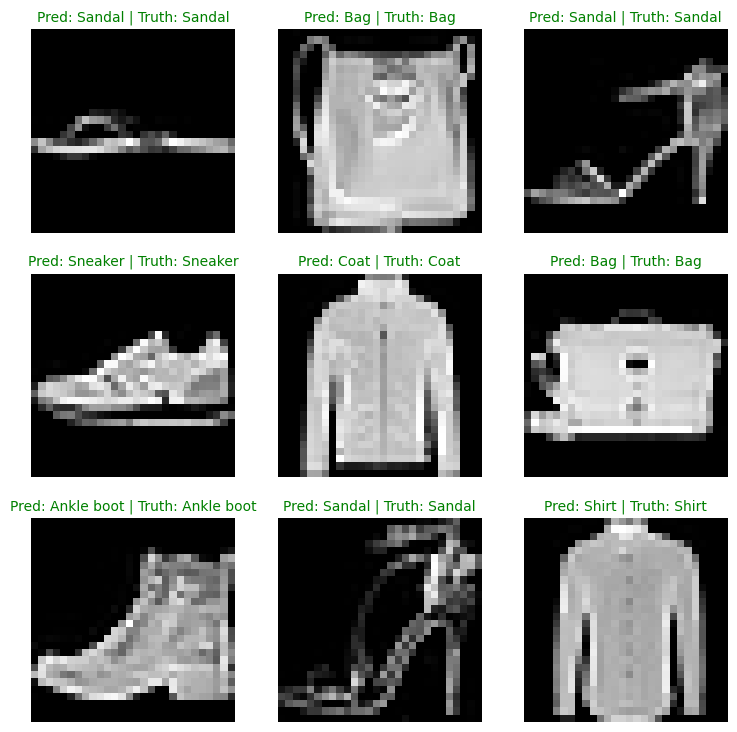

In [64]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False);

## 10. Making a confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluating your models visually

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()` - http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/


In [65]:
# Import tqdm.auto
from tqdm.auto import tqdm


# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 2])

In [66]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 our higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version {mlxtend.__version__}")

mlxtend version: 0.23.0


SyntaxError: ignored

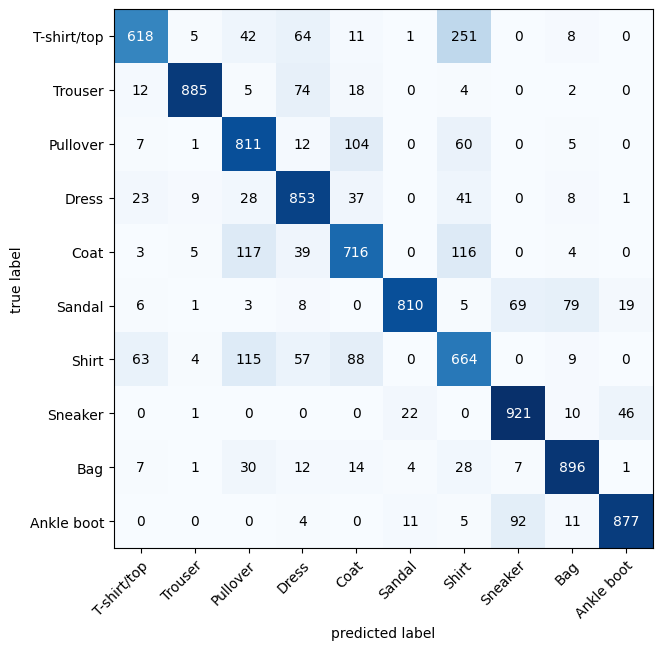

In [76]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass') # COnfusionMatrix requeres a task multiclass likewise
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 11. Save and load best perfoming model


In [81]:
from pathlib import Path

#Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

#Create model Save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

#Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [84]:
# Create a new instace
torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names))

# Load in the sabe state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [85]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3177354633808136,
 'model_acc': 88.72803514376997}

In [86]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3177354633808136,
 'model_acc': 88.72803514376997}

In [88]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)